### Constantes

In [1]:
IMAGE_SIZE = 256

labels = {'standing': 0, 'takedown': 1, 'open_guard': 2, 'half_guard': 3, 'closed_guard': 4, '5050_guard': 5, 'side_control': 6, 'mount': 7, 'back': 8, 'turtle': 9}
body_parts = ["nose", "left eye", "right eye", "left ear", "right ear", "left shoulder", "right shoulder", "left elbow", "right elbow", "left wrist", "right wrist", "left hip", "right hip", "left knee", "right knee", "left ankle", "right ankle"]
num_labels = len(labels)
num_keypoints = 17

### Importando modelo movenet

In [1]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

In [3]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker_heavy.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("../../test_images/standing.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


### Carregando modelo pose BJJ

In [3]:
import tensorflow as tf

model = tf.keras.models.load_model("jiu_model.h5")

### Funções úteis

In [5]:
import matplotlib.pyplot as plt # type: ignore
import numpy as np

def plot_movenet_prediction(img, keypoints_dict, label):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img[0])
    plt.subplot(1, 3, 2)
    plt.imshow(img[0])
    plt.title('Pose')
    plt.axis('off')
    
    for i in range(17):
        plt.scatter(keypoints_dict[label[i]][1],keypoints_dict[label[i]][0],color='green')

    connections = [
        ('nose', 'left eye'), ('left eye', 'left ear'), ('nose', 'right eye'), ('right eye', 'right ear'),
        ('nose', 'left shoulder'), ('left shoulder', 'left elbow'), ('left elbow', 'left wrist'),
        ('nose', 'right shoulder'), ('right shoulder', 'right elbow'), ('right elbow', 'right wrist'),
        ('left shoulder', 'left hip'), ('right shoulder', 'right hip'), ('left hip', 'right hip'),
        ('left hip', 'left knee'), ('right hip', 'right knee'), ('left knee', 'left ankle'), ('right knee', 'right ankle')
    ]

    for start_key, end_key in connections:
        if start_key in keypoints_dict and end_key in keypoints_dict:
            start_point = keypoints_dict[start_key][:2]  # Take first two values
            end_point = keypoints_dict[end_key][:2]      # Take first two values
            plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], linewidth=2)
    
    plt.subplot(1, 3, 3)
    plt.imshow((img[0]/255)/255)
    plt.title('Only Pose Image')
    for start_key, end_key in connections:
        if start_key in keypoints_dict and end_key in keypoints_dict:
            start_point = keypoints_dict[start_key][:2]  # Take first two values
            end_point = keypoints_dict[end_key][:2]      # Take first two values
            plt.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], linewidth=2)
            
def get_keypoints(image):
    X = tf.expand_dims(image, axis=0)
    X = tf.cast(tf.image.resize_with_pad(X, IMAGE_SIZE, IMAGE_SIZE), dtype=tf.int32)
    img = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE)
    img = tf.cast(img, dtype=tf.int32)
    img = tf.expand_dims(img, axis=0)
    img = img.numpy()
    outputs = movenet(X)
    keypoints = outputs['output_0'].numpy()
    return keypoints, img

def get_keypoints_dict(keypoints):
    max_key,key_val = keypoints[0,:,55].argmax(),keypoints[0,:,55].max()
    max_key,key_val
    max_points = keypoints[0,max_key,:]
    max_points = max_points*IMAGE_SIZE
    max_points = max_points.astype(float)
    keypoints_dict = {}
    for i in range(0,len(max_points)-5,3):
        keypoints_dict[body_parts[i//3]] = [max_points[i],max_points[i+1],max_points[i+2]]
    return keypoints_dict

def pose_prediction(keypoints):
    # normalize keypoints
    max_x = np.max(keypoints[:,0])
    
    keypoints = keypoints/max_x
    
    keypoints = keypoints[0]
    
    keypoints_batch = []
    
    for k in keypoints:
        keypoints_batch.append(k[:51])
        
    keypoints_batch = np.array(keypoints_batch)
    
    predictions = model.predict(keypoints_batch)
    
    return np.argmax(predictions[0])    

### Classificação em imagem única

1/1 [==============================] - 0s 93ms/step
Predicted Label:  side_control


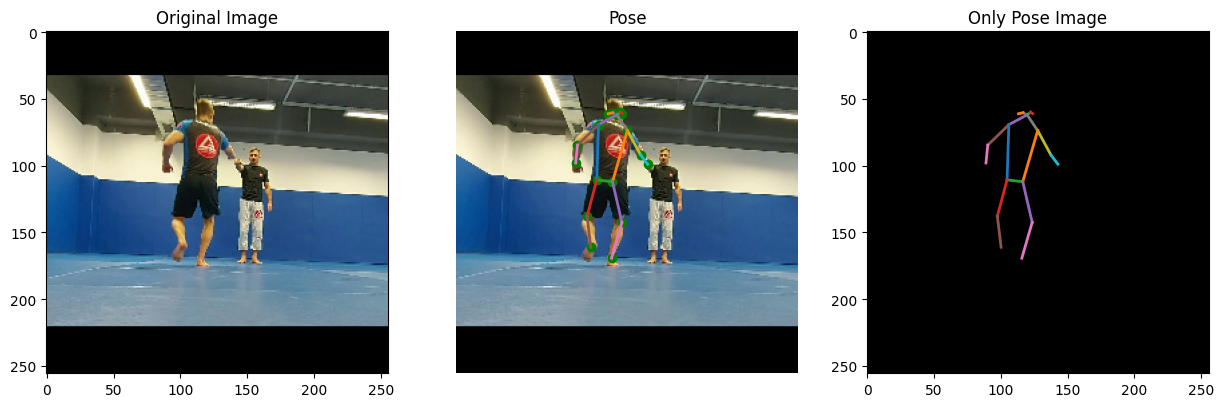

In [6]:
image_path = '../../test_images/standing02.jpg'
image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)

keypoints, img = get_keypoints(image)
keypoints_dict = get_keypoints_dict(keypoints)
label_index = pose_prediction(keypoints)

plot_movenet_prediction(img, keypoints_dict, body_parts)

print("Predicted Label: ", list(labels.keys())[label_index])

### Classificação em vídeo em tempo real

In [ ]:
import cv2 # type: ignore

cap = cv2.VideoCapture("../../test_videos/video.mp4")

while cap.isOpened():
    
    ret, frame = cap.read()
    
    if not ret:
        break
    
    frame = cv2.resize(frame, (IMAGE_SIZE, IMAGE_SIZE))
    
    keypoints, img = get_keypoints(frame)
    label_index = pose_prediction(keypoints)
    
    print("Predicted Label: ", list(labels.keys())[label_index])
    
    cv2.imshow("Frame", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break